# Convolve Fenics functions

Class FenicsRegularGridConvolver for convolving functions

\begin{equation*}
Tu := \psi \ast u
\end{equation*}

i.e.,

\begin{equation*}
(Tu)(y) = \int_\Omega \psi(y-x) u(x) dx
\end{equation*}

where

\begin{equation*}
\psi(x) := \phi(x+p)
\end{equation*}

for some centerpoint $p$ and function $\phi$ which are given.

$u \in V_u$ and $\phi \in V_\phi$ may be defined on different rectilinear meshes, as long as the mesh grids are aligned. $p$ should be a gridpoint

In [1]:
import numpy as np
import dolfin as dl
from scipy.signal import convolve

class FenicsRegularGridConvolver:
    # https://github.com/NickAlger/helper_functions/blob/master/fenics_convolution.ipynb
    def __init__(me, V_u, V_phi, p):
        d = V_u.mesh().geometric_dimension()
        u_coords = V_u.tabulate_dof_coordinates()
        phi_coords = V_phi.tabulate_dof_coordinates()

        me.u_sort_inds = np.lexsort(u_coords[:,::-1].T)
        me.phi_sort_inds = np.lexsort(phi_coords[:,::-1].T)

        me.U_shape = tuple(len(np.unique(u_coords[:,k])) for k in range(d))
        me.PHI_shape = tuple(len(np.unique(phi_coords[:,k])) for k in range(d))

        me.min_pt_phi = np.min(phi_coords, axis=0)
        me.max_pt_phi = np.max(phi_coords, axis=0)

        me.hh = (me.max_pt_phi - me.min_pt_phi) / (np.array(me.PHI_shape) - 1)

        me.ind_shift = np.round((p - me.min_pt_phi) / me.hh).astype(int)
        me.output_slices = tuple(slice(me.ind_shift[k], me.ind_shift[k] + me.U_shape[k])
                            for k in range(d))

        me.element_volume = np.prod(me.hh)

    def convolve(me, u, phi):
        U = u.vector()[me.u_sort_inds].reshape(me.U_shape)
        PHI = phi.vector()[me.phi_sort_inds].reshape(me.PHI_shape)

        TU0 = convolve(U, PHI)
        TU = TU0[me.output_slices]

        Tu = dl.Function(V_u)
        Tu.vector()[me.u_sort_inds] = TU.reshape(-1) * me.element_volume
        return Tu



# Run test

## Set up meshes

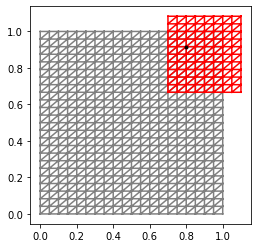

In [2]:
# To check correctness, set s large, like s=20,
# and observe Tu_q =approx= Tu_q_true at the bottom of the notebook
# s = 20
s=2

import matplotlib.pyplot as plt

min_pt_u = np.array([0., 0.])
max_pt_u = np.array([1, 1.])

nx_u = s*10
ny_u = s*12
hx = (max_pt_u[0] - min_pt_u[0])/nx_u
hy = (max_pt_u[0] - min_pt_u[0])/ny_u

u_mesh = dl.RectangleMesh(dl.Point(min_pt_u), dl.Point(max_pt_u),nx_u, ny_u)

min_pt_phi = np.array([s*7.*hx, s*8.*hy])
max_pt_phi = np.array([s*11.*hx, s*13.*hy])
phi_mesh = dl.RectangleMesh(dl.Point(min_pt_phi), dl.Point(max_pt_phi), s*4, s*5)

nx_phi = s*11 - s*7
ny_phi = s*13 - s*8

p = np.array([s*8.*hx, s*11.*hy])

dl.plot(u_mesh)
dl.plot(phi_mesh,color='r')
plt.plot(p[0], p[1], '.k')

V_u = dl.FunctionSpace(u_mesh, 'CG', 1)
V_phi = dl.FunctionSpace(phi_mesh, 'CG', 1)

## Define $u$ and $\phi$

phi_vol= 0.9999999999999999


Text(0.5, 1.0, 'u')

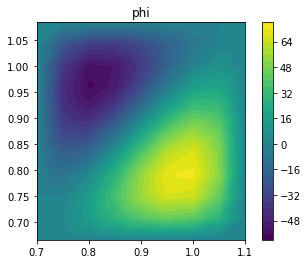

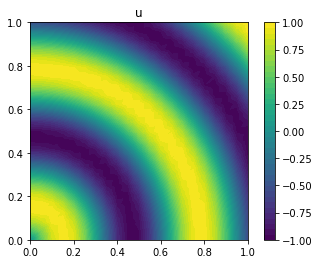

In [3]:
phi_expr = dl.Expression('-(x[0]-a)*(x[0]-b)*(x[1]-c)*(x[1]-d)*sin(3*(x[0]-x[1]))',
                         a=min_pt_phi[0], b=max_pt_phi[0],
                         c=min_pt_phi[1], d=max_pt_phi[1],
                         e=p[1],
                         degree=5, domain=phi_mesh)

phi = dl.interpolate(phi_expr, V_phi)

phi_vol0 = dl.assemble(phi * dl.dx)
phi.vector()[:] = phi.vector()[:] / phi_vol0
phi_vol = dl.assemble(phi * dl.dx)

print('phi_vol=', phi_vol)

cm = dl.plot(phi)
plt.colorbar(cm)
plt.title('phi')

u_expr = dl.Expression('sin(10*sqrt(x[0]*x[0] + x[1]*x[1]))', domain=u_mesh, degree=5)
u = dl.interpolate(u_expr, V_u)

plt.figure()
cm = dl.plot(u)
plt.colorbar(cm)
plt.title('u')

## Use FenicsRegularGridConvolver() to convolve

Text(0.5, 1.0, 'Tu')

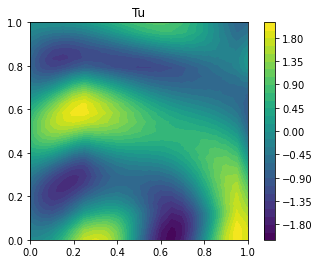

In [4]:
FRGC = FenicsRegularGridConvolver(V_u, V_phi, p)
Tu = FRGC.convolve(u, phi)

cm = dl.plot(Tu)
plt.colorbar(cm)
plt.title('Tu')

## Check results

To check, we compute the convolution result at a point $q$ via direct integration of the formula,

\begin{equation*}
(Tu)(q) = \int u(x) \phi(q-(x-p)) dx
\end{equation*}

In [5]:
old_coords = phi_mesh.coordinates()[:].copy()

Text(0.5, 1.0, 'flipped translated phi')

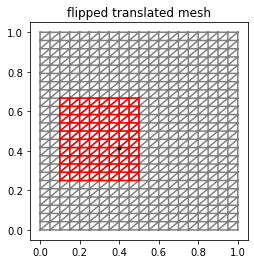

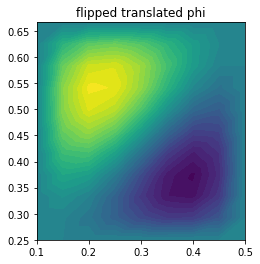

In [6]:
q = np.array([s*4*hx, s*5*hy])

# flip the mesh and recenter it at q instead of p
phi_mesh.coordinates()[:] = -(old_coords - p.reshape((1,-1))) + q.reshape((1,-1))

dl.plot(u_mesh)
dl.plot(phi_mesh, color='r')
plt.title('flipped translated mesh')
plt.plot(q[0], q[1], '.k')

plt.figure()
dl.plot(phi)
plt.title('flipped translated phi')

In [7]:

Tu_q_true = dl.assemble(dl.interpolate(u, V_phi) * phi * dl.dx)
Tu_q = Tu(q)

print('Tu_q_true=',Tu_q_true, ', Tu_q=', Tu_q)



Tu_q_true= 0.23278519086437763 , Tu_q= 0.24803308813590605
